# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# TD2 - Régression linéaire

Ce TD concerne la régression linéaire (Chapitre 2 du cours). À la fin de ce TD, vous devriez être avoir été en mesure de
- Estimer les coefficients des paramères de régression avec la méthode des moindres carrés.
- Valider les hypothèeses de régression à l'aide de l'analyse des résidus.
- Tester l'importance de la régression.
- Calculer des intervalles de confiances sur les coefficients et sur les prévisions.
- Vérifier la présence de multicolinéarité. 

Pour les deux premiers exercices, je vous suggère de ne utiliser la librairie GLM pour bien comprendre tous les concepts. La librairie GLM peut être utilisée pour le troisième exercice.

In [473]:
# Chargement des librairies
using CSV, DataFrames, Gadfly, Statistics, LinearAlgebra

# Exercice 1 - Pourcentage de gras

Le pourcentage de gras est un indice de forme physique d'un individu. Or, la mesure de cet indice est assez difficile. Elle requiert l'immersion complète de l'individu dans un cylindre gradué rempli d'eau. 

Par conséquent, on souhaite savoir si on peut prédire le pourcentage de gras $Y$ avec trois mesures beaucoup plus simples à obtenir :

$x_1$ : l'épaisseur des plis de la peau des triceps (en mm) ;<br/>
$x_2$ : le tour de cuisse (en mm) ;<br/>
$x_3$ : la circonférence du bras en (mm).<br/>

Les mesures du fichier *bodyfat.csv* proviennent de 20 femmes en bonne santé, âgées entre 20 et 34 ans. 

In [474]:
# Chargement des données
data = CSV.read("bodyfat.csv")
first(data,5)

,Triceps,Thigh,Midarm,Bodyfat
,Float64,Float64,Float64,Float64
1,19.5,43.1,29.1,11.9
2,24.7,49.8,28.2,22.8
3,30.7,51.9,37.0,18.7
4,29.8,54.3,31.1,20.1
5,19.1,42.2,30.9,12.9


## a) Affichage du pourcentage de graisse en fonction du tour de cuisse

Tracer le nuage de points du pourcentage de graisse en fonction de $x_2$, le tour de cuisse. Est-ce qu'une relation linéaire semble appropriée ?

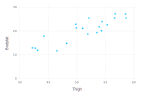

In [475]:
layer_a = layer(data, x=:Thigh,y=:Bodyfat, Geom.point)
plot(layer_a)

## b) Estimation des paramètres de la régression linéaire simple

Estimez les paramètres du modèle de régression linéaire entre le pourcentage de graisse et $x_2$, le tour de cuisse.

In [476]:
function estimate(d::Array{Float64,2}, Y::Array{Float64,1})
    n = size(d)[1]::Int
    X = [ones(n) d]
    β = (X'X)\X'Y
    
    return β
end

estimate (generic function with 6 methods)

In [477]:
β = estimate(data.Thigh, data.Bodyfat)

2-element Array{Float64,1}:
 -23.634489130310737 
   0.8565465923453338

## c) Affichage de la droite de régression obtenue

Superposez au nuage de points précédent la droite de régression estimée.

┌ Warning: color("red") is deprecated, use colorant"red" or parse(Colorant, "red")
│   caller = top-level scope at In[478]:1
└ @ Core In[478]:1


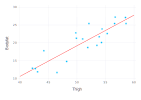

In [478]:
layer_c = layer(x=40:10:60, y=[β[1]+x*β[2] for x in 40:10:60], Geom.line, Theme(default_color=color("red")))
plot(layer_a,layer_c)

## d) Calul du $R^2$ ajusté et du $R^2$ de prévision.

Calculez pour le modèle de régression linéaire simple défini en (b) :
- le $R^2$ ajusté ;
- le $R^2$ de prévision.

In [479]:
function predict(d, beta)
    n = size(d)[1]::Int
    X = [ones(n) d]
    y = X*beta
    return y
end
function R_ajuste(X, y, beta)
    n = size(X)[1]::Int
    ŷ = predict(X, beta)
    ȳ = mean(y)
    p = size(beta)[1]-1
    SSₑ = (y - ŷ)'*(y - ŷ)
    SSₜ = (y .- ȳ)'*(y .- ȳ)
    R²ajusté = 1 - (SSₑ/(n-p))/(SSₜ/(n-1))
    return R²ajusté
end
function R_prev(d, y, beta)
    n = size(d)[1]::Int
    X = [ones(n) d]
    H = X/(X'X)*X'
    ŷ = predict(d, beta)
    e = y - ŷ 
    ẽ = e./(1 .- diag(H))
    SSₜ = (y .- ȳ)'*(y .- ȳ)
    R²prev = 1 - (ẽ'ẽ)/SSₜ
end

R_prev (generic function with 1 method)

In [480]:
R²ajusté = R_ajuste(data.Thigh, data.Bodyfat, β)

0.7710414083275696

In [481]:
R²prev = R_prev(data.Thigh, data.Bodyfat, β)

0.8194557890250483

## e) Vérification de la multicolinéarité 

Si toutes les variables explicatives sont utilisées, vérifiez s'il y a présence de multicolinéarité.

In [482]:
function check_multicol(X::Array{T,2} where T<:Real)
   
    # Standardize first the explanatory variables
    m = mean(X, dims=1)
    s = std(X, dims=1)
    
    m[1] = 0
    s[1] = 1
    
    X̃ = (X .- m) ./s
    
    
    # compute the singular values
    λ = svdvals(X̃)
    # Calculer les valeurs singulières de X est plus efficace que calculer les valeurs propres de X'X
    
    # Coompute the multicollinearity index
    ϕ = maximum(λ) / minimum(λ)
    
    return ϕ > 30
end

check_multicol (generic function with 1 method)

In [483]:
check_multicol([ones(size(data)[1]) data.Midarm data.Thigh data.Triceps])

true

## f) Régression avec l'épaisseur du pli du triceps et la circonférence du bras

Estimez les paramètres du modèle de régression utilisant l'épaisseur du pli du triceps et la circonférence du bras comme variables explicatives.

In [484]:
β = estimate([data.Midarm data.Triceps], Array{Float64}(data.Bodyfat))

3-element Array{Float64,1}:
  6.791627412442195  
 -0.43144201802196935
  1.0005849091216994 

## g) Validation des hypothèses de la régression

Tracez les résidus en fonction des prévisions. Est-ce que les hypothèses de la régression semblent satisfaites ?

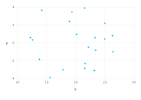

In [485]:
function graph_residus(X, y, beta)
    ŷ = predict(X, beta)
    e = y - ŷ
    plot(x=ŷ, y=e)
end
graph_residus([data.Midarm data.Triceps], data.Bodyfat, β)

## h) Calul du $R^2$ ajusté et du $R^2$ de prévision.

Calculez pour le modèle de régression linéaire simple défini en (f) :
- le $R^2$ ajusté ;
- le $R^2$ de prévision.

In [486]:
R²ajusté = R_ajuste([data.Midarm data.Triceps], data.Bodyfat, β)

0.7742798394106003

In [487]:
R²prev = R_prev([data.Midarm data.Triceps], data.Bodyfat, β)

0.8008000774702125

## i) Sélection de modèle

Lequel des modèles définis en (b) et (f) est le meilleur ? Justifiez.

Ça dépend du critère. Si on intéressé à la prévision, alors le meilleur modèle est celui utilisant uniquement le tour de cuisse car son $R^2$ de prévision est supérieur.


# Exercice 2 - Notes de MTH2302B


Le jeu de données *notes.csv}* compile les notes obtenues aux deux contrôles périodiques et au final des 91 étudiants inscrits dans mes sections du cours MTH2302B pour les sessions A2017 et H2018. Durant la session d'automne, la majorité des étudiants provenait de génie chimique et génie biomédical tandis qu'à la session d'hiver, les étudiant provenaient majoritairement de génie mécanique et de génie aérospatial.

On souhaite déterminer s'il existe une relation linéaire entre la note au final ($Y$) et la note au premier contrôle ($X_1$) et la note au deuxième contrôle ($X_2$).


In [488]:
# Chargement des librairies
using CSV, DataFrames, Gadfly, Statistics, LinearAlgebra, Distributions

In [489]:
# Chargement des données
data = CSV.read("notes.csv")
first(data,5)

,CP1,CP2,Final,Session
,Float64,Float64,Float64,String
1,13.75,16.5,27.75,A2017
2,9.5,11.5,14.25,A2017
3,11.0,10.25,22.75,A2017
4,10.75,13.0,26.0,A2017
5,10.75,6.5,22.0,A2017


## a) Estimation des paramètres du modèle de régression

Estimez les paramètres du modèle de régression :
$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon.$$

In [490]:
β = estimate([data.CP1 data.CP2], Array{Float64}(data.Final))

3-element Array{Float64,1}:
 12.224032934946093  
  0.31297174542620615
  0.6112804788597581 

## b) Validation des hypothèses de la régression

Validez les hypothèses de la régression avec le graphique des résidus

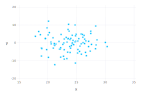

In [491]:
graph_residus([data.CP1 data.CP2], data.Final, β)

## c) Test sur l'importance de la régression

Testez au seuil de 5% si au moins une des variables explicatives possède un pouvoir prédictif significatif.

In [492]:
function test_fisher(X, y, beta, alpha)
    ŷ = predict(X, beta)
    ȳ = mean(y)
    SSₑ = (y - ŷ)'*(y - ŷ)
    SSᵣ = (ŷ .- ȳ)'*(ŷ .- ȳ)
    p = size(beta)[1]-1
    n = size(X)[1]::Int
    F₀ = (SSᵣ/p)/(SSₑ/(n-p-1))
    return ccdf(FDist(p, n-p-1), F₀) < alpha
end
test_fisher([data.CP1 data.CP2], data.Final, β, 0.05)

true


## d) Est-ce que la session à laquelle les étudiants étaient inscrits joue un rôle  significatif ?

In [493]:
session = [s == "H2018" for s in data.Session]
X = hcat(data.CP1, data.CP2, session)
β = estimate(X, Array{Float64}(data.Final))

4-element Array{Float64,1}:
 13.706094637032319 
  0.321860379556036 
  0.6137879296359796
 -2.6848507695193797

In [494]:
function intervalle_confiance(X, y, beta, alpha)
    ŷ = predict(X, beta)
    ȳ = mean(y)
    p = size(beta)[1]-1
    n = size(X)[1]::Int
    σ² = (y - ŷ)'*(y - ŷ)/(n-p-1)
    
    X = hcat(ones(length(data.Final)), data.CP1, data.CP2, session)
    c = diag(inv(X'X))
    t = cdf(TDist(n-p-1), alpha)
    
    Δβ = t.*sqrt.(σ².*c)
    return [(β - Δβ) (β + Δβ)][2:end,:]
end

intervalle_confiance (generic function with 1 method)

In [495]:
#intervalle de confiance de β̂  de la variable session
intervalle_confiance(X, data.Final, β, 0.975)[3,:]

2-element Array{Float64,1}:
 -3.533953529789581 
 -1.8357480092491785

## e) Prévision de la note au final.

Supposons qu'un étudiant ait obtenu les notes de $13/20$ et de $15/20$ respectivement aux deux premiers contrôles périodiques:

 - $x_1 = 13/20$;
 - $x_2 = 15/20$.

Obtenez les estimations de sa note au final s'il était inscrit à la session A2017 et s'il était inscrit à la session H2018.

In [496]:
X = [13 15 0; 13 15 1]
ŷ = predict(X, β)

2-element Array{Float64,1}:
 27.097098515800482
 24.412247746281103

# Exercice 3 - Résistance au cisaillement

Le jeu de données *visco.csv* contient la résistance au cisaillement (en kPa) d'un composé de caoutchouc en fonction de la température de durcissement (en degré Celcius). 

Pour cet exercice, utilisez la librairie GLM.

In [497]:
using CSV, DataFrames, Gadfly, Statistics, LinearAlgebra, GLM

In [498]:
# chargement des données
data = CSV.read("viscosite.csv")

,Temperature,Resistance
,Int64,Int64
1,138,5309
2,140,5516
3,144,5792
4,146,5585
5,148,5068
6,152,4413
7,153,4068
8,157,3861


In [499]:
# Changement du nom de la variable pour faciliter la manipulation
rename!(data, :Temperature => :T)
rename!(data, :Resistance => :R)

,T,R
,Int64,Int64
1,138,5309
2,140,5516
3,144,5792
4,146,5585
5,148,5068
6,152,4413
7,153,4068
8,157,3861


## a) Affichage de la résistance au cisaillement en fonction de la température

Affichez la résistance au cisaillement en fonction de la température.

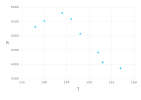

In [500]:
plot(data, x=:T, y=:R)

## b) Estimez les paramètres du modèle linéaire et calculez le $R^2$ ajusté

In [503]:
M₁ = lm(@formula(R ~ T), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

R ~ 1 + T

Coefficients:
──────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error   t value  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  19166.6       3495.66    5.48297    0.0015  10613.0    27720.2   
T              -96.5373      23.719  -4.07003    0.0066   -154.576    -38.4989
──────────────────────────────────────────────────────────────────────────────

In [504]:
R²ajusté = R_ajuste(data.T, data.R, coef(M₁))

0.734103533902955

## c) Estimez les paramètres du modèle quadratique et calculez le $R^2$ ajusté

In [509]:
data[!, :T2] = data[:, :T].^2
M₂ = lm(@formula(R ~ T + T2), data)

┌ Warning: `T` is deprecated, use `nonmissingtype` instead.
│   caller = (::getfield(StatsModels, Symbol("##40#41")){Array{Int64,1}})(::Array{Int64,1}) at none:0
└ @ StatsModels .\none:0


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

R ~ 1 + T + T2

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                 Estimate   Std. Error   t value  Pr(>|t|)    Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)    -1.48395e5  66815.7      -2.22096    0.0770    -3.2015e5  23360.1     
T            2182.9          908.436     2.40292    0.0614  -152.308      4518.11    
T2             -7.73865        3.08357  -2.50964    0.0539   -15.6652        0.187905
─────────────────────────────────────────────────────────────────────────────────────

In [511]:
R²ajusté = R_ajuste([data.T data.T2], data.R, coef(M₂))

0.8627173272489898

## d) Estimez les paramètres du modèle cubique et calculez le $R^2$ ajusté

In [ ]:
data[!, :T3] = data[:, :T].^3
M₂ = lm(@formula(R ~ T + T2 +), data)